**Date**: 2018-07-16

**Authors**: Yichen Fang

**Purpose**: To test the effect of padding sequences at the front

**Background**:
- The previous tests are all based on the padding scheme which attaches null positions at the end of a short sequence. We suspect that procedure might produce bad results when using RNN. This is because RNN analyses the sequence from front to end position by position, and, if padding is at the end, the null positions would introduce a lot of noises into the RNN model, disturbing the final accuracy.

**Experiment**:

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

Load the `pickle` buffered list:

In [3]:
with open("../data/list_buffer.txt", "rb") as buff:
    seq_record_list = pickle.load(buff)

The following cell transforms the data into a format that is recognizable by the neural network model.
**Note**: Unlike in previous notebooks, the `curtail` function now add null values at the front of the sequence instead of the end.

In [4]:
# A helper function to flatten a 2d list to 1d.
# Input: [[1, 2], [2, 3], [3, 4, 5]]
# Output: [1, 2, 2, 3, 3, 4, 5]
def flatten(lst):
    new_lst = []
    for sub_lst in lst:
        for item in sub_lst:
            new_lst.append(item)
    return new_lst

# A helper function to transform a lst so that its length becomes read_len by:
# 1. If len(lst) > read_len, curtail the front of the lst.
# 2. If len(lst) < read_len, keep extending the front of the lst with 0 (NA).
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[-read_len:]
    else:
        for i in range(read_len - len(lst)):
            lst = [[0, 0, 0, 0, 0, 0, 0]] + lst
    return lst

# Produce the train-test split
# length_read: the length that you want all DNA sequences to conform to
def prepare_input(training_size, test_size, length_read):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    seq_count = 0
    while seq_count < training_size:
        X_train.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_train.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    while seq_count < (training_size + test_size):
        X_test.append(flatten(curtail(seq_record_list[seq_count][3], length_read)))
        y_test.append(int(seq_record_list[seq_count][1]))
        seq_count += 1
    return X_train, y_train, X_test, y_test

# Turn list into numpy tensors that can directly feed into a neural network model
def to_np_array(X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    if len(y_train.shape) == 1:
        y_train = np.transpose(np.array([y_train]))
    X_test = np.array(X_test)
    y_test = np.transpose(np.array(y_test))
    if len(y_test.shape) == 1:
        y_test = np.transpose(np.array([y_test]))
    return X_train, y_train, X_test, y_test

In [47]:
seq_record_list[520]

['VT19346|1|MEMB003F|+|3779',
 '1',
 'MEMB003F',
 [[1, 0, 0, 0, -2.99108576775, -9.05528259277, -8.40326213837],
  [0, 0, 0, 1, -1.99108576775, -4.3003950119, -6.14022731781],
  [0, 0, 0, 1, -2.52160048485, -4.3003950119, -0.930773973465],
  [0, 0, 0, 1, 0.115829482675, -3.3003950119, -5.14022731781],
  [0, 0, 0, 1, -1.88417053223, -4.3003950119, -3.14022731781],
  [0, 1, 0, 0, -1.40612328053, -1.76988017559, -7.5552649498],
  [0, 0, 1, 0, -2.88417053223, -2.01088833809, -4.20162773132],
  [0, 0, 1, 0, -2.88417053223, -4.59585094452, -5.20162773132],
  [0, 0, 0, 1, -2.52160048485, -1.71543240547, 0.0692260414362],
  [0, 0, 1, 0, -1.52160048485, -1.01088833809, 0.00782549660653],
  [0, 0, 1, 0, -2.10656285286, -1.27392268181, 0.0462996438146],
  [0, 0, 1, 0, 0.593876779079, -2.35484266281, -5.5552649498],
  [0, 1, 0, 0, 0.0633620619774, 2.28901338577, -0.0594097971916],
  [1, 0, 0, 0, -2.10656285286, -4.73335456848, -3.15533423424],
  [0, 0, 0, 1, 2.59387683868, 2.02153325081, -0.892299

In [15]:
X_train, y_train, X_test, y_test = prepare_input(9600, 1152, 2000)
X_train, y_train, X_test, y_test = to_np_array(X_train, y_train, X_test, y_test)
[X_train.shape, y_train.shape, X_test.shape, y_test.shape]

[(9600, 14000), (9600, 1), (1152, 14000), (1152, 1)]

The following cells build a recurrent network with four GRU layers, with 8, 8, 4, 4 units respectively:

In [19]:
from keras.models import Model, Sequential
from keras.layers import Dense, CuDNNLSTM, CuDNNGRU

In [20]:
X_train_rnn = X_train.reshape(9600, 2000, 7)

In [48]:
model = Sequential()
model.add(CuDNNGRU(8, input_shape=(2000, 7), return_sequences=True))
model.add(CuDNNGRU(8, return_sequences=True))
model.add(CuDNNGRU(4, return_sequences=True))
model.add(CuDNNGRU(4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_rnn, y_train, epochs=50, batch_size=128, validation_split=0.1)

Train on 8640 samples, validate on 960 samples
Epoch 1/50
8640/8640 [==============================] - 44s 5ms/step - loss: 0.6823 - acc: 0.5777 - val_loss: 0.6816 - val_acc: 0.5750
Epoch 2/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6810 - acc: 0.5778 - val_loss: 0.6815 - val_acc: 0.5750
Epoch 3/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6809 - acc: 0.5778 - val_loss: 0.6816 - val_acc: 0.5750
Epoch 4/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6809 - acc: 0.5778 - val_loss: 0.6813 - val_acc: 0.5750
Epoch 5/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6808 - acc: 0.5778 - val_loss: 0.6813 - val_acc: 0.5750
Epoch 6/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6808 - acc: 0.5778 - val_loss: 0.6812 - val_acc: 0.5750
Epoch 7/50
8640/8640 [==============================] - 42s 5ms/step - loss: 0.6807 - acc: 0.5778 - val_loss: 0.6811 - val_acc: 0.5750
Epoch 8/

**Result**:

The following cell **visualize** the training/validation accuracies and losses over each epoch.

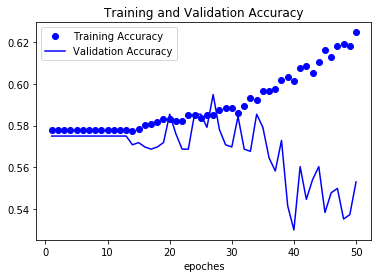

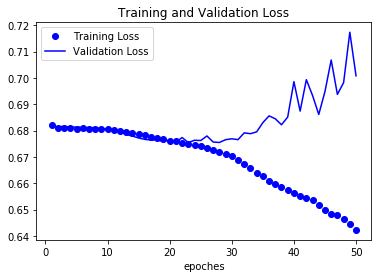

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

- Note that the trend of validation accuracy follows the trend of the training accuracy more closely as compared to trimming length 1500, indicating that the validation data is picking up more useful information from the training data when the trmming length is 1000.

**Conclusion**:

- As shown on the graph above, putting the padding at the front of sequences indeed leads to vastly different behaviour.
- Currently the model becomes divergent too early. More testing is required to make a firm conclusion.